In [1]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.contrib.layers.python.layers import initializers
from tensorflow.examples.tutorials.mnist import input_data
from math import sqrt
import numpy as np
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/ilyakryukov/anaconda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['sqrt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=False)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
learning_rate = 0.01
training_epochs = 10
batch_size = 100
display_step = 1
logs_path = './tensorflow_logs/mnist_metrics'
# Network Parameters
n_hidden_1 = 256 # 1st layer number of features
n_hidden_2 = 256 # 2nd layer number of features
n_input = 28*28 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)
margin = 1.0

In [4]:
x_left = tf.placeholder(tf.float32, shape=[None, n_input], name='InputDataLeft')
x_right = tf.placeholder(tf.float32, shape=[None, n_input], name='InputDataRight')
label = tf.placeholder(tf.float32, shape=[None, 1], name='LabelData') # 0 if the same, 1 is different
x_image_left = x_left
x_image_right = x_right

In [5]:
def fc(input, size, name):
    # Create variable named "weights".
    weights = tf.get_variable("weights", size, initializer=tf.random_normal_initializer())
    # Create variable named "biases".
    biases = tf.get_variable("biases", size[1], initializer=tf.constant_initializer(0.0))
    return tf.add(tf.matmul(input, weights), biases)

def fc_relu(input, size, name):
    # Create variable named "weights".
    weights = tf.get_variable("weights", size, initializer=tf.random_normal_initializer())
    # Create variable named "biases".
    biases = tf.get_variable("biases", size[1], initializer=tf.constant_initializer(0.0))
    return tf.nn.relu(tf.add(tf.matmul(input, weights), biases))

In [6]:
def tfNN(x):
    x = tf.scalar_mul(1.0/256.0, x)
    with tf.variable_scope("layer_1"):
        layer_1 = fc_relu(x, [n_input, n_hidden_1], "l1")
    with tf.variable_scope("layer_2"):
        layer_2 = fc_relu(layer_1, [n_hidden_1, n_hidden_2], "l2")
    with tf.variable_scope("layer_3"):
        layer_3 = fc(layer_2, [n_hidden_2, 10], "l3")
    with tf.variable_scope("out_layer"):
        out_layer = fc(layer_3, [10, 2], "l4")
    return out_layer

In [7]:
with tf.variable_scope('Model') as scope:
    # Model
    pred_left = tfNN(x_image_left)
    scope.reuse_variables()
    pred_right = tfNN(x_image_right)
with tf.name_scope('Loss'):
    d = tf.reduce_sum(tf.square(tf.sub(pred_left, pred_right)), 1, keep_dims=True)
    d_sqrt = tf.sqrt(d)
    loss = label * tf.square(tf.maximum(0.0, margin - d_sqrt)) + (1 - label) * d
    loss = 0.5 * tf.reduce_mean(loss)
    
with tf.name_scope('AdamOptimizer'):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

In [8]:
# Initializing the variables
init = tf.global_variables_initializer()
# Create a summary to monitor cost tensor
tf.scalar_summary("loss", loss)
# Merge all summaries into a single op
merged_summary_op = tf.merge_all_summaries()

In [9]:
# Launch the graph
sess = tf.Session()
sess.run(init)
# op to write logs to Tensorboard
summary_writer = tf.train.SummaryWriter(logs_path, graph=tf.get_default_graph())

# Training cycle
for epoch in range(training_epochs):
    avg_loss = 0.0
    total_batch = int(mnist.train.num_examples / batch_size)
    # Loop over all batches
    for i in range(total_batch):
        left_batch_xs, left_batch_ys = mnist.train.next_batch(batch_size)
        right_batch_xs, right_batch_ys = mnist.train.next_batch(batch_size)
        labels = np.zeros((batch_size, 1))
        for l in range(batch_size):
            if left_batch_ys[l] == right_batch_ys[l]:
                labels[l, 0] = 0.0
            else:
                labels[l, 0] = 1.0
        _, l, summary = sess.run([optimizer, loss, merged_summary_op],
                                 feed_dict = {
                                              x_left: left_batch_xs, 
                                              x_right: right_batch_xs,
                                              label: labels,
                                             })
        # Write logs at every iteration
        summary_writer.add_summary(summary, epoch * total_batch + i)
        # Compute average loss
        avg_loss += l / total_batch
    # Display logs per epoch step
    if (epoch+1) % display_step == 0:
        print ("Epoch:", '%04d' % (epoch+1), "loss =", "{:.9f}".format(avg_loss))

print ("Training Finished!")
print ("Run the command line:\n" \
      "--> tensorboard --logdir=./tensorflow_logs " \
      "\nThen open http://0.0.0.0:6006/ into your web browser")

Epoch: 0001 loss = 0.575065077
Epoch: 0002 loss = 0.077738510
Epoch: 0003 loss = 0.067698449
Epoch: 0004 loss = 0.062791694
Epoch: 0005 loss = 0.053076465
Epoch: 0006 loss = 0.047843853
Epoch: 0007 loss = 0.044116634
Epoch: 0008 loss = 0.038491831
Epoch: 0009 loss = 0.035552842
Epoch: 0010 loss = 0.033168024
Training Finished!
Run the command line:
--> tensorboard --logdir=./tensorflow_logs 
Then open http://0.0.0.0:6006/ into your web browser


In [10]:
# Test model
# Calculate accuracy
test_xs, test_ys = mnist.test.next_batch(5000)
ans = sess.run([pred_left], feed_dict = { x_left: test_xs})

In [11]:
ans = ans[0]

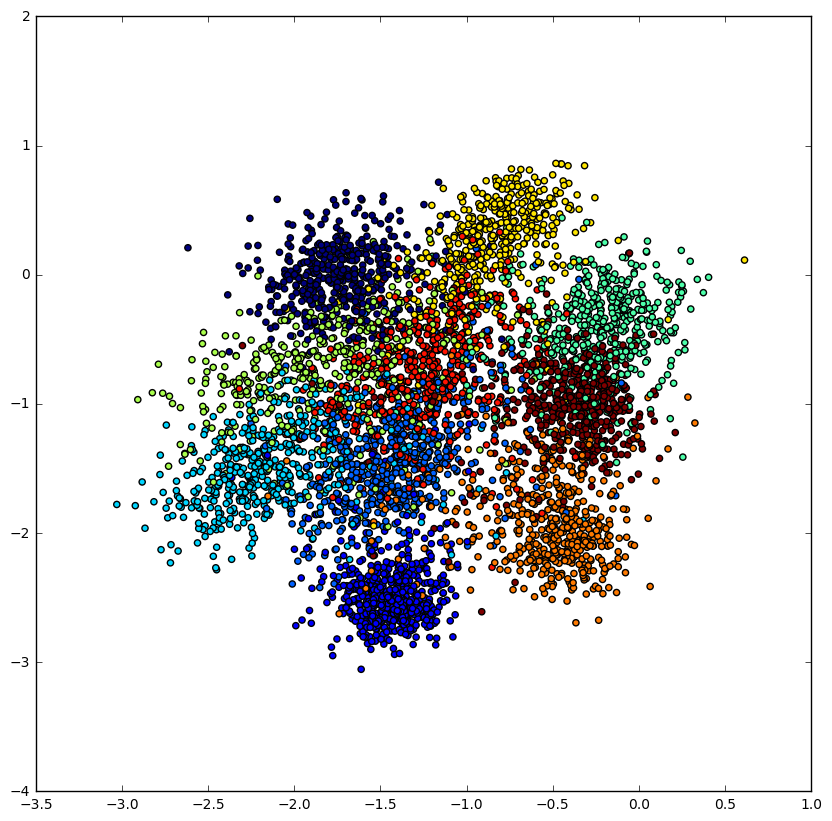

In [12]:
figure(figsize=(10,10))
scatter(ans[:,0], ans[:,1], c=test_ys[:])